In [ ]:
import jax
from jax import jit, grad, vmap
import jax.numpy as jnp
from flax import nn, optim

import gym
from functools import partial
import numpy as np

import random
from IPython.display import clear_output
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

#Hyperparameters

In [ ]:
max_episodes = 1000
max_steps    = 300
BATCH_SIZE   = 128
GAMMA        = 0.99
BUFFER_SIZE  = 1000000
NOISE        = 0.1
POLYAK       = 0.995
SEED         = 1729

#Plotting

In [ ]:
def plot(episode, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'episode {episode}. reward: {np.mean(rewards[-10:])}')
    plt.plot(rewards)
    plt.show()
    plt.savefig(fname=f"~/eps_{episode}")

# Replay Buffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = jnp.expand_dims(state, 0)
        next_state = jnp.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return {'state': jnp.concatenate(state), 'action':jnp.asarray(action), 
                'reward':jnp.asarray(reward), 
                'next_state':jnp.concatenate(next_state), 'done':jnp.asarray(done)}
    
    def __len__(self):
        return len(self.buffer)

#Normalize Action Space

In [ ]:
@jit
def scale_action(lower_bound, upper_bound, action):
  #(action - min(tanh))/(max(tanh) - min(tanh)) *(max_act - min_act) + min_act
  action = lower_bound + (action + 1.0) * 0.5 * (upper_bound - lower_bound) 
  action = jnp.clip(action, lower_bound, upper_bound)
        
  return action

#Network

In [ ]:
@jit
def polyak_average(old, new):
  return jax.tree_multimap(
    lambda p_ema, p: p_ema * POLYAK + p * (1. - POLYAK), old, new)

In [ ]:
class Critic(nn.Module):
  def apply(self, s, a):
    x = jnp.concatenate((s, a), axis=1)
    x = nn.Dense(x, 400)
    x = nn.relu(x)    
    x = nn.Dense(x, 300)
    x = nn.relu(x)
    x = nn.Dense(x, 1)
    return x

class Actor(nn.Module):
  def apply(self, x, action_dim):
    x = nn.Dense(x, 400)
    x = nn.relu(x)    
    x = nn.Dense(x, 300)
    x = nn.relu(x)
    x = nn.Dense(x, action_dim)
    x = jnp.tanh(x)
    return x

#Training

In [ ]:
@jit
def policy(model, key, obs, noise):
  action = model(obs)
  return action + jax.random.normal(key, action.shape)*noise

# @jit
def actor_step(actor_optimizer, critic, actor_target, state):
  def actor_loss(actor, critic, state):
    a = actor(state)
    q = critic(state, a)
    return jnp.mean(q)
  
  actor_grad = grad(actor_loss)(actor_optimizer.target, critic, state)
  actor_optimizer = actor_optimizer.apply_gradient(actor_grad)
  
  actor_target = actor_target.replace(params=
      polyak_average(actor_target.params, actor_optimizer.target.params))
  return actor_optimizer, actor_target 

@vmap 
def q_loss(reward, done, q_target, q):
  td_target = reward + GAMMA*(1. - done)*q_target
  return (jax.lax.stop_gradient(td_target) - q)**2

# @jit
def critic_step(critic_optimizer, actor_target, critic_target, batch):
  done = batch['done']
  state = batch['state']
  reward = batch['reward']
  action = batch['action']
  next_state = batch['next_state']
  
  def critic_loss(critic):  
    q = critic(state, action)
    q_target = critic_target(next_state, actor_target(next_state)) 
    return jnp.mean(q_loss(reward, done, q_target, q))

  critic_grad = grad(critic_loss)(critic_optimizer.target)
  critic_optimizer = critic_optimizer.apply_gradient(critic_grad)
  
  critic_target = critic_target.replace(params=
      polyak_average(critic_target.params, critic_optimizer.target.params))

  return critic_optimizer, critic_target


@jit
def train_step(actor_optimizer, critic_optimizer, actor_target, 
               critic_target, batch):
  actor_optimizer, actor_target = actor_step(actor_optimizer, 
                                             critic_optimizer.target, 
                                             actor_target, batch['state'])
  critic_optimizer, critic_target = critic_step(critic_optimizer, actor_target,
                                                critic_target, batch)
  
  return (actor_optimizer, critic_optimizer), (actor_target, critic_target)
   

def main_loop():
  # Build env
  noise = NOISE
  env = gym.make("Pendulum-v0")
  replay_buffer = ReplayBuffer(BUFFER_SIZE)
  key = jax.random.PRNGKey(SEED)
  lower_bound   = env.action_space.low
  upper_bound = env.action_space.high      
  
  #logging
  rewards = []
  episode_reward = 0
  ep_idx = 0

  # Build and initialize Network.
  action_dim = env.action_space.shape[0]
  state = env.reset()

  a_module = Actor.partial(action_dim=action_dim)
  sample_action, initial_params = a_module.init(key, state)
  actor = nn.Model(a_module, initial_params)
  actor_target = nn.Model(a_module, initial_params)

  _, initial_params = Critic.init(key, jnp.expand_dims(state, axis=0), 
                                  jnp.expand_dims(sample_action, axis=0))
  critic = nn.Model(Critic, initial_params)
  critic_target = nn.Model(Critic, initial_params)

  # Build and initialize optimizer.
  actor_optimizer = optim.Adam(1e-4).create(actor)
  critic_optimizer = optim.Adam(1e-3).create(critic)

  rng = [key]

  for ep_idx in range(max_episodes):
    state = env.reset()
    episode_reward = 0
    rng = jax.random.split(rng[0], max_steps)
    
    for step in range(max_steps):
      action = policy(actor, rng[step], state, noise)
      action = scale_action(lower_bound, upper_bound, action)
      next_state, reward, done, _ = env.step(action)
        
      replay_buffer.push(state, action, reward, next_state, done)
      if len(replay_buffer) > BATCH_SIZE:
        batch = replay_buffer.sample(BATCH_SIZE)
        (actor_optimizer, critic_optimizer), (actor_target, critic_target) = \
        train_step(actor_optimizer, critic_optimizer, 
                         actor_target, critic_target, batch)
            
      if done:
        break
      state = next_state
      episode_reward += reward
      
    rewards.append(episode_reward)
    if ep_idx % 100 == 0:
      # print(actor_optimizer.target.params['0']['kernel'][:10, 0])
      # print(actor_target.params['0']['kernel'][:10, 0], "\n")
      # print(critic_optimizer.target.params['0']['kernel'][:10, 0])
      # print(critic_target.params['0']['kernel'][:10, 0], "\n\n")
      # noise /= 2
      plot(ep_idx, rewards)

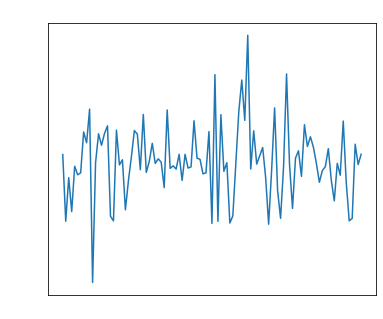

In [ ]:
main_loop()